In [1]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
import shapely

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [2]:
#input file
file_forecast = 'https://files.bwsi-remote-sensing.net/data/final_2024/day3/day3_forecasts_2024.geojson'

In [3]:
# Forecasts
forecast = gpd.read_file(file_forecast)

In [4]:
random_color = lambda: np.random.random(3)

In [5]:
# look at the forecasts
forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2023-08-05 08:00:00,95,2,POINT (-71.4427 42.35526)
1,1,24,2023-08-05 20:00:00,90,2,POINT (-70.9599 43.29834)
2,1,36,2023-08-06 08:00:00,70,1,POINT (-70.13339 43.85976)
3,1,48,2023-08-06 20:00:00,65,1,POINT (-68.53599 43.32475)
4,1,60,2023-08-07 08:00:00,55,0,POINT (-68.0575 43.94382)
...,...,...,...,...,...,...
115,20,24,2023-08-05 20:00:00,90,2,POINT (-70.93159 43.32967)
116,20,36,2023-08-06 08:00:00,70,1,POINT (-70.29009 43.66332)
117,20,48,2023-08-06 20:00:00,65,1,POINT (-69.37494 44.56669)
118,20,60,2023-08-07 08:00:00,55,0,POINT (-68.60862 43.28433)


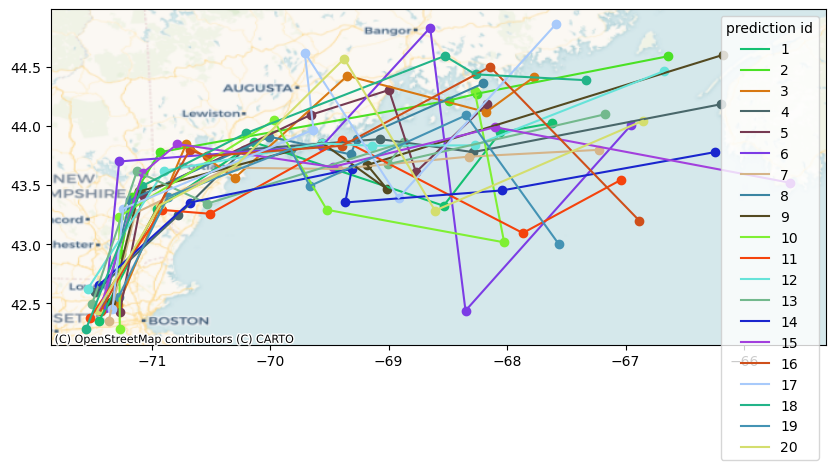

In [6]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')
ctx.add_basemap(ax,
               crs=forecast.crs,
               source=ctx.providers.CartoDB.Voyager
              )

In [7]:
#put it in meters
forecast_utm = forecast.to_crs(forecast.estimate_utm_crs())
                 
forecast_utm["x"] = forecast_utm.geometry.x
forecast_utm["y"] = forecast_utm.geometry.y

forecast_utm.head()

,prediction,forecastHour,datetime,maxWinds,category,geometry,x,y
0,1,12,2023-08-05 08:00:00,95,2,POINT (298824.807 4692111.888),298824.806624,4.692112e+06
1,1,24,2023-08-05 20:00:00,90,2,POINT (341025.327 4795810.633),341025.326732,4.795811e+06
2,1,36,2023-08-06 08:00:00,70,1,POINT (408917.101 4856920.741),408917.101170,4.856921e+06
3,1,48,2023-08-06 20:00:00,65,1,POINT (537620.762 4796982.745),537620.761633,4.796983e+06
4,1,60,2023-08-07 08:00:00,55,0,POINT (575635.604 4866065.204),575635.603867,4.866065e+06


In [8]:
#centroids
centroid_utm = (forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=forecast_utm.crs ))
    )


centroid_utm.head()

,forecastHour,x,y,geometry
0,12,302663.762933,4.706081e+06,POINT (302663.763 4706080.62)
1,24,337565.719386,4.812817e+06,POINT (337565.719 4812817.438)
2,36,411898.016461,4.847138e+06,POINT (411898.016 4847138.245)
3,48,486724.678704,4.865300e+06,POINT (486724.679 4865299.974)
4,60,547280.273778,4.839958e+06,POINT (547280.274 4839957.503)


In [9]:
#distances between points and centroids
dist_gdf = (forecast_utm
 .merge(centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(radius_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

,prediction,forecastHour,datetime,maxWinds,category,geometry_orig,x,y,geometry_cent,radius_m
0,1,12,2023-08-05 08:00:00,95,2,POINT (298824.807 4692111.888),298824.806624,4.692112e+06,POINT (302663.763 4706080.62),14486.651353
1,1,24,2023-08-05 20:00:00,90,2,POINT (341025.327 4795810.633),341025.326732,4.795811e+06,POINT (337565.719 4812817.438),17355.123046
2,1,36,2023-08-06 08:00:00,70,1,POINT (408917.101 4856920.741),408917.101170,4.856921e+06,POINT (411898.016 4847138.245),10226.586665
3,1,48,2023-08-06 20:00:00,65,1,POINT (537620.762 4796982.745),537620.761633,4.796983e+06,POINT (486724.679 4865299.974),85191.871905
4,1,60,2023-08-07 08:00:00,55,0,POINT (575635.604 4866065.204),575635.603867,4.866065e+06,POINT (547280.274 4839957.503),38543.959445
...,...,...,...,...,...,...,...,...,...,...
115,20,24,2023-08-05 20:00:00,90,2,POINT (343402.159 4799236.394),343402.159076,4.799236e+06,POINT (337565.719 4812817.438),14782.042868
116,20,36,2023-08-06 08:00:00,70,1,POINT (395985.008 4835288.107),395985.007958,4.835288e+06,POINT (411898.016 4847138.245),19840.604966
117,20,48,2023-08-06 20:00:00,65,1,POINT (470227.166 4934885.834),470227.166240,4.934886e+06,POINT (486724.679 4865299.974),71514.752537
118,20,60,2023-08-07 08:00:00,55,0,POINT (531753.294 4792464.719),531753.294087,4.792465e+06,POINT (547280.274 4839957.503),49966.505457


In [10]:
radii = dist_gdf.groupby("forecastHour", as_index=False)[["radius_m"]].mean()
radii

,forecastHour,radius_m
0,12,13659.548850
1,24,22367.532673
2,36,37855.617248
3,48,52690.928472
4,60,55308.066252
5,72,68795.928453


In [11]:
#.pipe switches the grouped dataframe to a geodataframe
forecast_radius_m_utm = (centroid_utm
                            .merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
forecast_radius_m_utm

,forecastHour,x,y,geometry,radius_m
0,12,302663.762933,4.706081e+06,POINT (302663.763 4706080.62),13659.548850
1,24,337565.719386,4.812817e+06,POINT (337565.719 4812817.438),22367.532673
2,36,411898.016461,4.847138e+06,POINT (411898.016 4847138.245),37855.617248
3,48,486724.678704,4.865300e+06,POINT (486724.679 4865299.974),52690.928472
4,60,547280.273778,4.839958e+06,POINT (547280.274 4839957.503),55308.066252
5,72,651471.000546,4.881197e+06,POINT (651471.001 4881197.122),68795.928453


In [12]:
# fig, ax = plt.subplots(1, 1, figsize=(10,10))

# forecast_circle.plot(ax=ax)

# ctx.add_basemap(ax,
#                crs=forecast_circle.crs,
#                source=ctx.providers.OpenStreetMap.Mapnik
#               )

In [13]:
forecast_circle  = forecast_radius_m_utm.copy()
forecast_circle['geometry'] = forecast_circle.geometry.buffer(forecast_circle.radius_m)
forecast_circle = forecast_circle.drop(columns=["x", "y"])
forecast_circle = forecast_circle.to_crs(epsg=4326)
forecast_circle

,forecastHour,geometry,radius_m
0,12,"POLYGON ((-71.23486 42.4853, -71.23523 42.4732...",13659.548850
1,24,"POLYGON ((-70.73125 43.45516, -70.73202 43.435...",22367.532673
2,36,"POLYGON ((-69.62437 43.77559, -69.62628 43.742...",37855.617248
3,48,"POLYGON ((-68.50887 43.93977, -68.51241 43.893...",52690.928472
4,60,"POLYGON ((-67.72672 43.70555, -67.73105 43.656...",55308.066252
5,72,"POLYGON ((-66.25033 44.05085, -66.25726 43.990...",68795.928453


In [14]:
from shapely.ops import unary_union
polygon_list = forecast_circle.geometry.tolist()
coastline_cone = unary_union(MultiPolygon(polygon_list).convex_hull)
coastline_cone
coastline_cone_gdf = gpd.GeoDataFrame(index=[0], geometry=[coastline_cone], crs='EPSG:4326')
coastline_cone_gdf

,geometry
0,"POLYGON ((-71.39623 42.35903, -71.4125 42.3592..."


In [15]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged



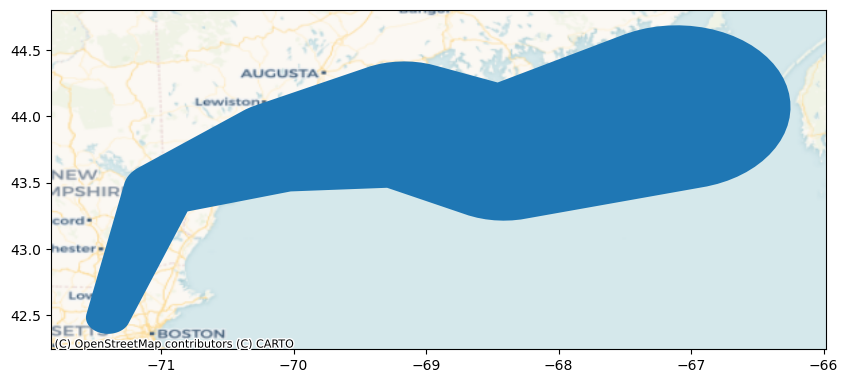

In [16]:
cone = visualizeUncertainty(forecast_circle.to_crs(epsg=4326))
fig, ax = plt.subplots(1, 1, figsize=(10,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, )


ctx.add_basemap(ax,
               crs=forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()

In [17]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

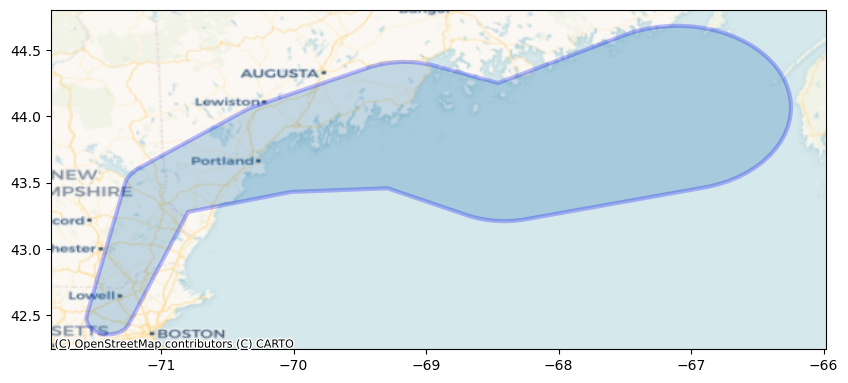

In [18]:
cone = visualizeUncertainty(forecast_circle)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, alpha= 0.25, edgecolor= "blue", linewidth= 3)


ctx.add_basemap(ax,
               crs=forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()


In [99]:
!pip install shapely geojson

# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_track_past.geojson')
day1_track.plot()

# Location of Areas of Interest


In [30]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip -O R1-Hospitals.zip
!unzip R1-Hospitals.zip

--2024-08-03 01:01:57--  https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 52.32.177.214, 54.186.10.246, 34.213.124.230, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|52.32.177.214|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-03 01:01:57 ERROR 404: Not Found.

Archive:  R1-Hospitals.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Hospitals.zip or
        R1-Hospitals.zip.zip, and cannot find R1-Hospitals.zip.ZIP, period.


In [31]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip -O R1-Shelters.zip
!unzip R1-Shelters.zip

--2024-08-03 01:02:00--  https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 34.213.124.230, 54.201.69.220, 52.32.177.214, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|34.213.124.230|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-03 01:02:00 ERROR 404: Not Found.

Archive:  R1-Shelters.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Shelters.zip or
        R1-Shelters.zip.zip, and cannot find R1-Shelters.zip.ZIP, period.


In [32]:
!pip install fiona

In [19]:
import rasterio
import rasterio.plot
import rasterio.merge 
import rasterio.mask
import pyproj
import osmnx as ox
import geopandas as gpd
import pandas as pd
# !pip install fiona
import fiona
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [20]:
# import necessary libraries
import ee
import geemap
ee.Authenticate()
ee.Initialize()

In [21]:
cone_json = shapely.geometry.mapping(cone)
cone_GEE = ee.Feature(cone_json)

In [22]:
#vis params because they take too much space
vis_params = {
    'min': -25,            # Minimum value for color scaling
    'max': 700,        # Maximum value for color scaling
    'palette': ['blue', 'green', 'yellow', 'red']  # Color palette (optional)
}

viz_pop = {
    "min": 0.0,
    "max": 1000.0,
    "palette": ["#f7fcf0", "#e0f3f8", "#bfd3c1", "#f4a582", "#d73027"]
}

viz_svi = {
    "min": 0.0,  
    "max": 1.0,  
    "palette": ['blue', 'green', 'yellow', 'purple']  
}


/tmp/ipykernel_3339/3347153008.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  intersection = gpd.overlay(coastline, forecast_circle, how='intersection')


<Axes: >

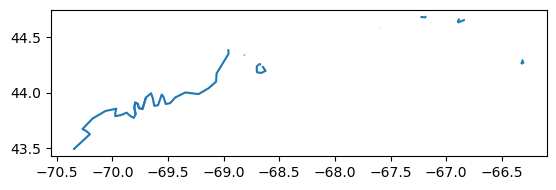

In [24]:
coastline = gpd.read_file("ne_50m_coastline.shp")
#cone_gdf = gpd.GeoDataFrame(index=[0], geometry=[cone], crs=coastline.crs)

# Find the intersection
intersection = gpd.overlay(coastline, forecast_circle, how='intersection')
intersection.plot()
# Save or inspect the result
#intersection.to_file('path_to_intersection_shapefile.shp')

In [25]:
srtm = ee.Image('USGS/SRTMGL1_003') #Load DEM from USGS

coastline = gpd.read_file("ne_50m_coastline.shp") #Load coastline shapefile
coastline.crs = "EPSG:4326"  # Set CRS

coastline_cone_gdf.crs = "EPSG:4326"  # Set CRS

# Find the intersection
intersection = gpd.overlay(coastline, coastline_cone_gdf, how='intersection') #Find intersection between coastline and hurricane path

intersection_gdf = gpd.GeoDataFrame(geometry=intersection.geometry) #Convert geoseries to a GeoDataFrame
intersection_gdf = intersection_gdf.to_crs(epsg=3857) #Convert CRS to meters
intersection_gdf['geometry'] = intersection_gdf['geometry'].buffer(5000) #Add a 5km buffer
intersection_gdf = intersection_gdf.to_crs(epsg=4326) #Convert CRS back to LAT and LON

geometry = intersection_gdf.unary_union #Merge all the unusual geometry to get a clean product

intersection_gdf = gpd.GeoDataFrame(index=[0], geometry=[geometry], crs='EPSG:4326') #Convert geoseries to a GeoDataFrame

ee_coastline = geemap.gdf_to_ee(intersection_gdf) #Convert a GeoDataFrame into a google ee image

forecast_centers = forecast_radius_m_utm.copy().drop(columns=['radius_m']) #Drop the radius_m column, I just didn't like it

#PS: The code below repeats a LOT
#------------------Zone 80---------------------------#
zone_80 = forecast_centers.copy() #Create a copy
zone_80 = zone_80.to_crs(epsg=3857) #Convert CRS to meters
zone_80['geometry'] = zone_80['geometry'].buffer(80 * 1000) #Add an 80km buffer
zone_80 = zone_80.to_crs(epsg=4326) #Convert CRS back to LAT and LON
ee_zone80 = geemap.gdf_to_ee(zone_80) #Convert a GeoDataFrame into a google ee image

intersection_80 = gpd.overlay(intersection_gdf, zone_80, how='intersection') #Find intersection between modified coastline and hurricane path centroids
intersection_80_gdf = gpd.GeoDataFrame(geometry=intersection_80.geometry) #Convert geoseries to a GeoDataFrame
ee_intersection_80 = geemap.gdf_to_ee(intersection_80_gdf) #Convert a GeoDataFrame into a google ee image
#------------------Zone 160---------------------------#
zone_160 = forecast_centers.copy()
zone_160 = zone_160.to_crs(epsg=3857)
zone_160['geometry'] = zone_160['geometry'].buffer(160 * 1000)
zone_160 = zone_160.to_crs(epsg=4326)
ee_zone160 = geemap.gdf_to_ee(zone_160)

intersection_160 = gpd.overlay(intersection_gdf, zone_160, how='intersection')
intersection_160_gdf = gpd.GeoDataFrame(geometry=intersection_160.geometry)
ee_intersection_160 = geemap.gdf_to_ee(intersection_160_gdf)
#------------------Zone 300---------------------------#
zone_300 = forecast_centers.copy()
zone_300 = zone_300.to_crs(epsg=3857)
zone_300['geometry'] = zone_300['geometry'].buffer(300 * 1000)
zone_300 = zone_300.to_crs(epsg=4326)
ee_zone300 = geemap.gdf_to_ee(zone_300)


intersection_300 = gpd.overlay(intersection_gdf, zone_300, how='intersection')
intersection_300_gdf = gpd.GeoDataFrame(geometry=intersection_300.geometry)
ee_intersection_300 = geemap.gdf_to_ee(intersection_300_gdf)

#---------Adding layers and masks to google map-----------#
srtm = srtm.updateMask(srtm.gt(0)) #Remove the ocean and areas with an elevation less than or equal to 0
srtm_masked_6 = srtm.updateMask(srtm.lt(6)).clip(ee_intersection_80) #Get areas under 6 meters of elevation
srtm_masked_4 = srtm.updateMask(srtm.lt(4)).clip(ee_intersection_160) #Get areas under 4 meters of elevation
srtm_masked_3 = srtm.updateMask(srtm.lt(3)).clip(ee_intersection_300) #Get areas under 3 meters of elevation

Map = geemap.Map() #Initialize a map

Map.addLayer(srtm_masked_3, {
    'min': -25,      
    'max': 700,
    'palette': ['#bb00c7']
}, 'DEM_updated3')
Map.addLayer(srtm_masked_4, {
    'min': -25,      
    'max': 700,
    'palette': ['#011f4b']
}, 'DEM_updated4')
Map.addLayer(srtm_masked_6, {
    'min': -25,      
    'max': 700,
    'palette': ['00FFFF']
}, 'DEM_updated6')

#Map.addLayer(ee_coastline, {}, "coastline")
Map.addLayer(cone_GEE, {}, 'Polygon')
#Map.addLayer(ee_zone300, {}, 'zone300')
#Map.addLayer(ee_zone160, {}, 'zone160')
#Map.addLayer(ee_zone80, {}, 'zone80')
#Map.addLayer(ee_intersection_300, {}, 'inter300')
#Map.addLayer(ee_intersection_160, {}, 'inter160')
#Map.addLayer(ee_intersection_80, {}, 'inter80')
Map.centerObject(cone_GEE, 10)

Map

/tmp/ipykernel_3339/975143437.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = intersection_gdf.unary_union #Merge all the unusual geometry to get a clean product


Map(center=[43.8089027428602, -68.68962342374535], controls=(WidgetControl(options=['position', 'transparent_b…